### Import all essential libraries

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from utils import *
from unet import *

In [2]:
#Setting size parameters of images
im_width = 256
im_height = 256

### Utilities

In [16]:



def dice_coefficients(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)


def dice_coefficients_loss(y_true, y_pred, smooth=100):
    return -dice_coefficients(y_true, y_pred, smooth)


def iou(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou


def jaccard_distance(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    return -iou(y_true_flatten, y_pred_flatten)

### Loading the image and mask paths

In [3]:
image_filenames_train = []

#Creating a list of all files containing the word 'mask'
mask_files = glob('C:/Users/katle/PycharmProjects/SDS Project/DS Projects/archive/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    image_filenames_train.append(i.replace('_mask',''))

print(image_filenames_train[:10])
len(image_filenames_train)

['C:/Users/katle/PycharmProjects/SDS Project/DS Projects/archive/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10.tif', 'C:/Users/katle/PycharmProjects/SDS Project/DS Projects/archive/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_11.tif', 'C:/Users/katle/PycharmProjects/SDS Project/DS Projects/archive/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_12.tif', 'C:/Users/katle/PycharmProjects/SDS Project/DS Projects/archive/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_13.tif', 'C:/Users/katle/PycharmProjects/SDS Project/DS Projects/archive/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_14.tif', 'C:/Users/katle/PycharmProjects/SDS Project/DS Projects/archive/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_15.tif', 'C:/Users/katle/PycharmProjects/SDS Project/DS Projects/archive/lgg-mri-segmentation/kaggle_3m\\TCG

3929

### Plotting few images and masks

In [4]:
def plot_from_img_path(rows, columns, list_img_path, list_mask_path):
    fig = plt.figure(figsize=(12, 12))
    for i in range(1, rows * columns + 1):
        fig.add_subplot(rows, columns, i)
        img_path = list_img_path[i]
        mask_path = list_mask_path[i]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path)
        plt.imshow(image)
        plt.imshow(mask, alpha=0.4)
    plt.show()

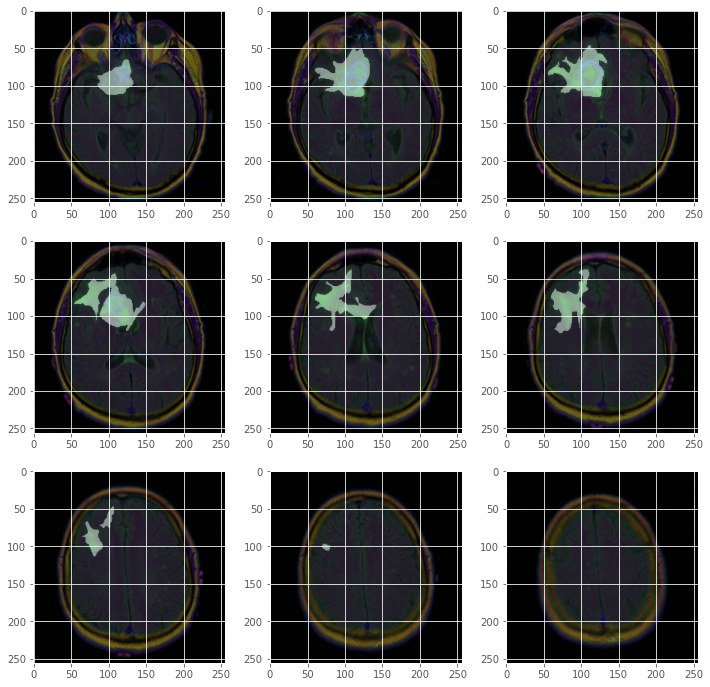

In [5]:
plot_from_img_path(3, 3 ,image_filenames_train, mask_files)

### Create dataframe and split data on train, validate, and test set

In [6]:
df = pd.DataFrame(data={'image_filenames_train': image_filenames_train, 'mask': mask_files})

df_train, df_test = train_test_split(df, test_size = 0.1)

#Further split this val and train
df_train, df_val = train_test_split(df_train, test_size = 0.2)

print(df.shape)
print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(3929, 2)
(2828, 2)
(393, 2)
(708, 2)


### Data generator, data augmentation, and adjust data

In [7]:
# Referring Code From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
    """
    If you wish to view the output of generator, you may produce image and mask at the same time 
    using the same seed for image datagen and mask datagen to guarantee the transformation for image and mask is the same.
    set save to dir = "your location"
    """
    
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filenames_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)
    
    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)

In [8]:
"""
If the result after mask Normalization is = 0.5, the mask is deemed completely black 
and has no Tumor.
"""
def normalize_and_diagnose(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return(img, mask)

In [18]:
#Hyperparameters
EPOCHS = 10
BATCH_SIZE = 32
learning_rate = 1e-4
smooth=100

In [19]:
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # First DownConvolution / Encoder Leg will begin, so start with Conv2D
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(pool4)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)

    """ Now UpConvolution / Decoder Leg will begin, so start with Conv2DTranspose
    The gray arrows (in the above image) indicate the skip connections that concatenate the encoder feature map with the decoder, which helps the backward flow of gradients for improved training. """
    up6 = concatenate(
        [
            Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn5
            ),
            conv4,
        ],
        axis=3,
    )
    """ After every concatenation we again apply two consecutive regular convolutions so that the model can learn to assemble a more precise output """
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate(
        [
            Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn6
            ),
            conv3,
        ],
        axis=3,
    )
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    up8 = concatenate(
        [
            Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn7
            ),
            conv2,
        ],
        axis=3,
    )
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    up9 = concatenate(
        [
            Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn8
            ),
            conv1,
        ],
        axis=3,
    )
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up9)
    bn9 = Activation("relu")(conv9)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
train_generator_param = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_param,
                                target_size=(im_height, im_width))
    
test_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
model = unet(input_size=(im_height, im_width, 3))



decay_rate = learning_rate / EPOCHS

opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)

model.compile(optimizer=opt, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])

callbacks = [ModelCheckpoint('unet.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/10
89/88 [==============================] - ETA: -54s - loss: -0.0837 - binary_accuracy: 0.8576 - iou: 0.0443 - dice_coefficients: 0.0838Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 1: val_loss improved from inf to -0.02209, saving model to unet.hdf5
88/88 [==============================] - 7982s 90s/step - loss: -0.0837 - binary_accuracy: 0.8576 - iou: 0.0443 - dice_coefficients: 0.0838 - val_loss: -0.0221 - val_binary_accuracy: 0.0215 - val_iou: 0.0108 - val_dice_coefficients: 0.0213
Epoch 2/10
89/88 [==============================] - ETA: -55s - loss: -0.1462 - binary_accuracy: 0.9794 - iou: 0.0799 - dice_coefficients: 0.1464
Epoch 2: val_loss did not improve from -0.02209
88/88 [==============================] - 8182s 92s/step - loss: -0.1462 - binary_accuracy: 0.9794 - iou: 0.0799 - dice_coefficients: 0.1464 - val_loss: -0.0220 - val_binary_accuracy: 0.9891 - val